# How to think about likelihoods over multiple samples

This notebook demonstrates how we treate a likelihood over multiple samples.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [8]:
import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from scipy.stats import norm

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_environment

In a previous notebook we showed how to scale hidden state inference with Bayes' theorem to multiple samples. In this notebook we will extend the explanation of the likelihood a step further. 

We will use the same assume the following:
* $x^*$: The true **external state** of the generative process.
* $y$: The **outcome** of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the external states of the generative process ($x^*$) denote the size of a food source and the outcomes ($y$) are represents levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer ("perceive") the hidden state of the generative process that generated the data it is receiving. This is represented by the variable ($x$), the **hidden state** which captures the agent's belief about the food size that could have generated the observed sensory data. We use the following agent and environment:

$$
    \mathscr{E} \triangleq 
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* x^* & \text{Generating function} \\
        \omega_y^* \sim \mathcal{N}(0, \sigma^2=1) & \text{Observation noise} \\
        \theta^* := \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Observation parameters}
    \end{cases}
$$

$$
    \mathcal{M} \triangleq 
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y_i \mid x) = \mathcal{N}(y_i; g_{\mathcal{M}}, \sigma^2_y) & \text{Likelihood} \\
        p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; m_x, s^2_x) & \text{Prior on } x \\
        g_{\mathcal{M}}(x, \theta) = \beta_0 + \beta_1 x & \text{Generating function} \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}  & \text{Linear parameters} \\ 
        \phi := \left \{\sigma^2_y = 0.25, s^2_x = 0.25, m_x = 4 \right \} & \text{Other parameters}
    \end{cases}
$$

The only difference is that observation are now indexed by $i = 0, \dots, N$ to indicate multiple samples are generated from the same hidden state. We use the linear environment we have used previously and generate $N=30$ samples with $x^*=2$.

In the previous notebook we generated a likelihood with multiple data points and showed that the result was a matrix. We recapitulate the results below. First, the environment must be created.

In [9]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 0.25  # Standard deviation of sensory data
}

# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)

# Generate data for three different x_star values
x_range = np.linspace(start=0.01, stop=5, num=500)   # Range of x_star
x_star  = 2                                          # External state
N       = 9                                         # Number of samples
y       = np.zeros(N)                                # Empty array for N=30 samples

# Generate
for i in range(N):
    env.build(x_star)
    y[i] = env.generate()
    
# The `norm()` function will not work unless we reshape `y` and add an extra dimension making it of size `[30, 1]`. The operation below adds this extra dimension. This is effectively like passing in 30 individual samples in one array instead of an array of 30 samples.

y = np.expand_dims(y, axis=1)

Now we create the likelihood for these 30 samples.

In [10]:
def generating_function(beta_0: float, beta_1: float, x: float) -> float:
    return beta_1 * x + beta_0

x_range = np.linspace(start=0.01, stop=5, num=500)
mu_y    = generating_function(beta_0=3, beta_1=2, x=x_range)

likelihood_i = norm.pdf(y, loc=mu_y, scale=0.5)

Checking the shape, we see that it has $N=9$ rows and 500 columns, one for each across the range of $x$ in the grid.

In [11]:
print(f"The shape of the likelihood is [{likelihood_i.shape[0]} x {likelihood_i.shape[1]}]")

The shape of the likelihood is [9 x 500]


Then we plot all of the likelihoods together.

**Note**: Plotting code heavily modified from matplotlib tutorial at: https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/

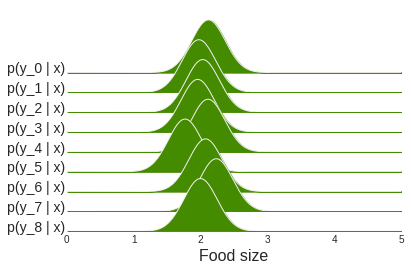

In [12]:
gs = grid_spec.GridSpec(len(likelihood_i) + 1,1)
fig = plt.figure(figsize=(6,4.5))

i = 0

ax_objs = []
for p in range(N):
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i + 1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_range, likelihood_i[p, :], color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_range, likelihood_i[p, :], alpha=1, color="#458B00")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,5)
    ax_objs[-1].set_ylim(0,1)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(likelihood_i)-1:
        ax_objs[-1].set_xlabel("Food size", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
 
    ax_objs[-1].text(-0.02,0, f'p(y_{p} | x)', fontsize=14,ha="right")
    
    i += 1
    plt.grid(visible=None)

gs.update(hspace=-0.7)
plt.show()

Now we take the product over these likelihoods (or sum if it were a log-likelihood) and get the following:

<Figure size 432x288 with 0 Axes>

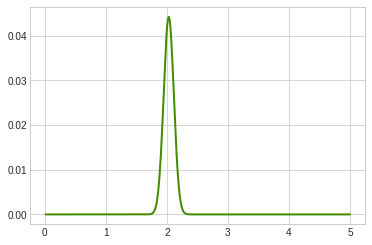

In [13]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
ax.plot(x_range, np.prod(likelihood_i, axis=0),
        c="#458B00",
        linewidth=2)